### Description:

In this task you will analyse software T-table AES-128 implementation running on ESP32 (see the code_sample.txt in the support folder).  

The software implementation does not contain any protection against side-channel attacks.

During one AES-128 execution a plaintext, a ciphertext and a real power trace of 5,000 samples were recorded.

10,000 encryptions were performed. Associated data (a plaintext, a ciphertext and a trace) was stored in HDF5 file.

One oscilloscope snapshot shows an entire AES execution, however, only the part related to encryption process, i.e., a part shown from 50 us to 60 us on the oscilloscope snapshot, is available for the analysis. 

The measurements were performed with LeCroy WaveRunner Zi625 and a differential probe.

### Tips:

A 'trace' is a side-channel information measured between the Vdd and the GND pins of the WROOM module (ESP32). 

Usually, CPU is vulnerable either to Hamming weight or to Hamming distance data models. There might be more than one instruction leaking secret data.

In this example a trace is a 5,000 bytes array of int8 (the amplitude of the measured voltage).

This array contains various encryption information measured with noise.

### Task:

You might perform several subtasks, but the main objective is to get the Master Key.

The master key is in the form of SCA{XXXXXXXXXXX}, where X is an ASCII printable symbol.

### AES-128 encryption measured at high sampling rate

Green signal - a GPIO trigger used to synchronize all the traces

Red signal   - VCC voltage variation during AES-128 encryption

<img src="support/osc_snap.png">

In [240]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import string
import binascii
import h5py
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
import subprocess
import sca_training

%matplotlib inline

datapath        = r'.'

hdffilename_data    = datapath + r'/data_ciphers.hdf5'
hdffilename_traces  = datapath + r'/data_traces.hdf5'

hdf5_dataset          = 'Traces'

numtraces   = 10000
numsamples  = 5000

#----------------------------------------------------------------------------
# OUTPUTS:
#     ptexts   - input plaintexts converted to numpy array of uint8
#     ctexts   - resulted ciphertext converted to numpy array of uint8
#     traces   - a trace associated with encryption process
#----------------------------------------------------------------------------

def ReadData():
    print('Reading data...')
    with h5py.File(hdffilename_data, 'r') as hdf5_data:      
        ptexts = hdf5_data['Ptexts'][:,:].astype('uint8')
        ctexts = hdf5_data['Ctexts'][:,:].astype('uint8')

    with h5py.File(hdffilename_traces, 'r') as hdf5_traces:      
        traces = hdf5_traces[hdf5_dataset][:,:].astype('int8')

    print('Ptexts size:', ptexts.shape)
    print('Ctexts size:', ctexts.shape)
    print('Traces size:', traces.shape)
    print('Completed')
    
    return ptexts, ctexts, traces

ptexts, ctexts, traces = ReadData()

Reading data...
Ptexts size: (10000, 16)
Ctexts size: (10000, 16)
Traces size: (10000, 5000)
Completed


### Task 0
Plot the mean for the first 1000 traces.

Do you see patterns? yes

Can you tell more about AES-128 operations?
I can see the rounds lol

(9947, 16)


Text(0.5, 1.0, 'Average of 9947 traces')

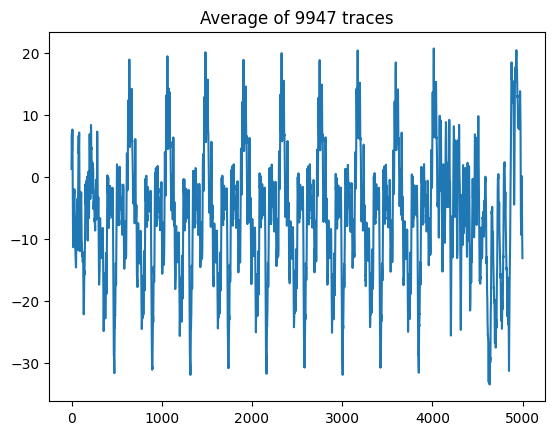

In [241]:
import matplotlib.pyplot as plt
%matplotlib inline

# Nettoyage des traces à trop haute variance

# Compute variance of all traces
vars = np.var(traces, axis=1)
threshold = 120
mask = vars < threshold
#mask = vars > 0

# Cleaning traces based on variance
clean_traces = traces[mask]
clean_ptexts = ptexts[mask]
clean_ctexts = ctexts[mask]
print(clean_ctexts.shape)

# Plot avg of traces
plt.plot(np.average(clean_traces, axis=0))
plt.title(f"Average of {len(clean_traces)} traces")

abs(avg(traces)) < Epsilon == 2.1715591803666477e-18 < 2.220446049250313e-16 == True


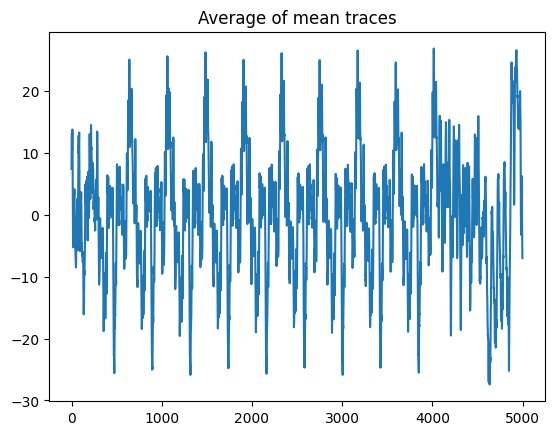

In [242]:
import sys
# Averaging traces
# This centers all the traces to 0
avg_traces = np.array([t - np.mean(t) for t in clean_traces])
plt.plot(np.mean(avg_traces,axis=0))
plt.title(f"Average of mean traces")
print(f"abs(avg(traces)) < Epsilon == {abs(np.mean(avg_traces))} < {sys.float_info.epsilon} == {abs(np.mean(avg_traces)) < sys.float_info.epsilon}")

### Task 1
Compute correlation with plaintexts and ciphertexts. There are few associated questions :

1. Do you consider correlation to be strong?
2. When is the correlation time?
3. Does the same model correlate only once?
4. Does different models correlate differently?
5. How can this correlation help us find the key?

In [243]:
import sca_training

# Absolute correlation of a vector on rows of a matrix
def matrix_corrcoef(matrix, vector):
    return np.array([abs(np.corrcoef(vector, row)[0][1]) for row in matrix])

# Transposing all the matrix to group the bytes on a vector (simpler indexing)
tt = avg_traces.transpose()
#tt = clean_traces.transpose()
print(f"Traces : {tt.shape}")

cts = clean_ctexts.transpose()
cts = np.array([sca_training.HW_uint8[ct] for ct in cts])
print(f"Ciphers: {cts.shape}")
corrs_ct = np.array([matrix_corrcoef(tt, ct) for ct in cts])
print(f"Corr   : {corrs_ct.shape}")

pts = clean_ptexts.transpose()
pts = np.array([sca_training.HW_uint8[pt] for pt in pts])
print(f"Plains : {pts.shape}")
corrs_pt = np.array([matrix_corrcoef(tt, pt) for pt in pts])
print(f"Corr   : {corrs_pt.shape}")

Traces : (5000, 9947)
Ciphers: (16, 9947)
Corr   : (16, 5000)
Plains : (16, 9947)
Corr   : (16, 5000)


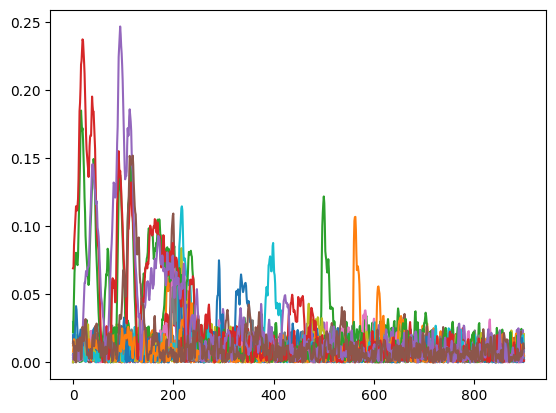

In [246]:
# Limitations du nombre de samples utilisés
start = 0
end = 900
[plt.plot(corr) for corr in corrs_pt[:,start:end]]
#[plt.plot(corr) for corr in corrs_ct[:,start:end]]
# Ce graphe montre que seuls les samples -410:-90 sont intéressants pour faire corréler les ciphers avec les traces
framed_traces = tt[start:end]

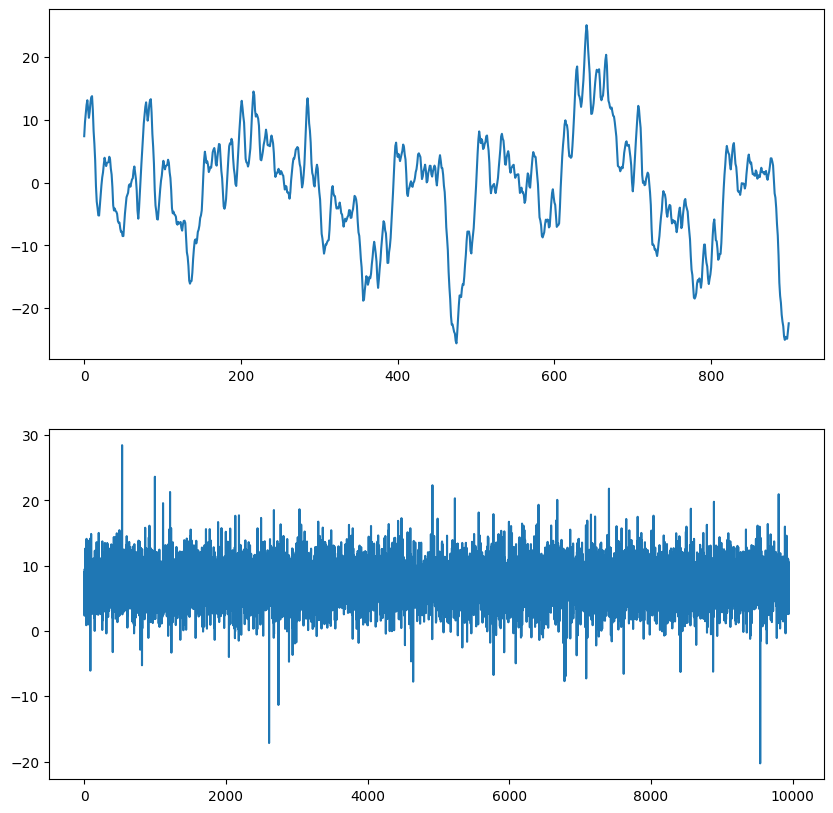

In [247]:
# Moyenne de toutes les traces, uniquement sur les samples sélectionnés
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))
ax[0].plot(np.average(framed_traces, axis=1))
ax[1].plot(framed_traces[0])

### Task 2

Create a model that involve any of the round keys. Use this model to find the round key. Prove that the key is correct.

In [250]:
# Limitation du nombre de traces utilisées
import random
array_size = 9947
if True:
    threshold = 70
    mask = np.array([random.randrange(0,100) for _ in range(array_size)]) > threshold
else:
    mask = [True]*array_size

t = framed_traces[:,mask]
c = clean_ptexts[mask].transpose()
p = clean_ptexts[mask].transpose()

print(t.shape)
print(t[100][:64])
print(c.shape)
print(c[4][:64])
print(p.shape)
print(p[4][:64])

(900, 2835)
[ 2.2752  0.115   3.624   6.7716  1.4662  9.6168 -0.8306  1.4884  3.7454
  4.1048  5.118   0.7648  0.0612 -0.2614  4.424   4.6778 -4.2478 -2.537
  2.0538  1.4874  1.844   2.8152  2.6456  5.4576 -1.5912  4.4652  1.9556
  1.1256  1.0554  4.8542  0.788   4.1912  4.5714  1.4254  0.4878  3.447
 -3.5602  3.119   8.206  -2.3958  5.9828  1.675  -0.839   0.2854  9.3746
  3.7384  2.6302  2.5262  3.0142  3.4076 -6.5358  1.0764  9.356   5.4276
  1.5932 -3.0892  2.8206  2.7096  1.6944  1.6902  1.3848  8.4194  0.683
  1.6198]
(16, 2835)
[213 224 210 112  33 212 197 106 170   6 255 182  96 105 237 231  37  92
  45 244  96 102 187 227 132  76  42 158  70 245 235 139 253  58  92  88
 145 152 254 152 142  40 205 187 195 245 116 147  46  18 234 108  78  31
 126 181  40 181 150 120 106 244 192  94]
(16, 2835)
[213 224 210 112  33 212 197 106 170   6 255 182  96 105 237 231  37  92
  45 244  96 102 187 227 132  76  42 158  70 245 235 139 253  58  92  88
 145 152 254 152 142  40 205 187 195 245 

In [251]:
import sca_training
import time
import datetime

k10_max = [0]*16
corrs_max = [[] for _ in range(16)]
for i in range(0,16):
    start_ms = round(time.time() * 1000)
    print("*"*60)
    print(i)
    pcc = 0
    k_max = 0
    corr_max = []
    for k in range(256):
        #cand = sca_training.HW_uint8[sca_training.invSbox[np.bitwise_xor(c[i], k)]]
        cand = sca_training.HW_uint8[sca_training.Sbox[np.bitwise_xor(p[i], k)]]
        all_corr = matrix_corrcoef(t, cand)
        corr = max(all_corr)
        if corr > pcc:
            pcc = corr
            k_max = k
            corr_max = all_corr
            print(pcc)
    k10_max[i] = k_max
    corrs_max[i] = corr_max

    stop_ms = round(time.time() * 1000)
    duration = round((stop_ms - start_ms) / 1000)
    length = str(datetime.timedelta(seconds=duration))
    print(f"Length : {length}")
    duration = duration * (15 - i)
    length = str(datetime.timedelta(seconds=duration))
    print(f"Left   : {length}")

************************************************************
0
0.057847116334979784
0.07780938227887682
0.08406537301680156
0.08457257329710675
0.233926431768882
Length : 0:00:09
Left   : 0:02:15
************************************************************
1
0.0659361085707931
0.10039055166706695
0.2548746357633008
Length : 0:00:09
Left   : 0:02:06
************************************************************
2
0.12442970340864642
0.342683409571315
Length : 0:00:09
Left   : 0:01:57
************************************************************
3
0.05995981940006322
0.06134821360128102
0.06399202751528685
0.0806169392207657
0.09462312078052958
0.186695587642681
Length : 0:00:09
Left   : 0:01:48
************************************************************
4
0.057557238992069736
0.06605797428736605
0.07247080015700216
0.07579410801828625
0.0761379128446135
0.07968928442558988
0.2536243068162393
Length : 0:00:09
Left   : 0:01:39
************************************************************
5
0

In [253]:
#mk = sca_training.inverse_key_expansion(np.array(k10_max))[0][0]
mk = k10_max
flag = ''.join(chr(c) for c in mk)
print(flag)

SCA{first win!!}


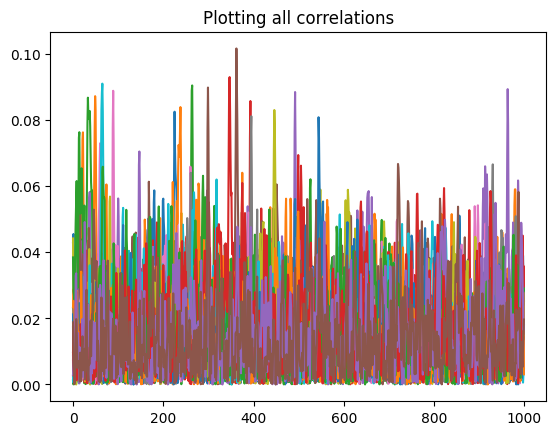

In [218]:
# Devrait corréler entre 1000 et 1500
if True:
    plt.title("Plotting all correlations")
    [plt.plot(corr) for corr in corrs_max]
else:
    i = 15
    plt.title(f"Plotting correlation for byte {i}")
    plt.plot(corrs_max[i])

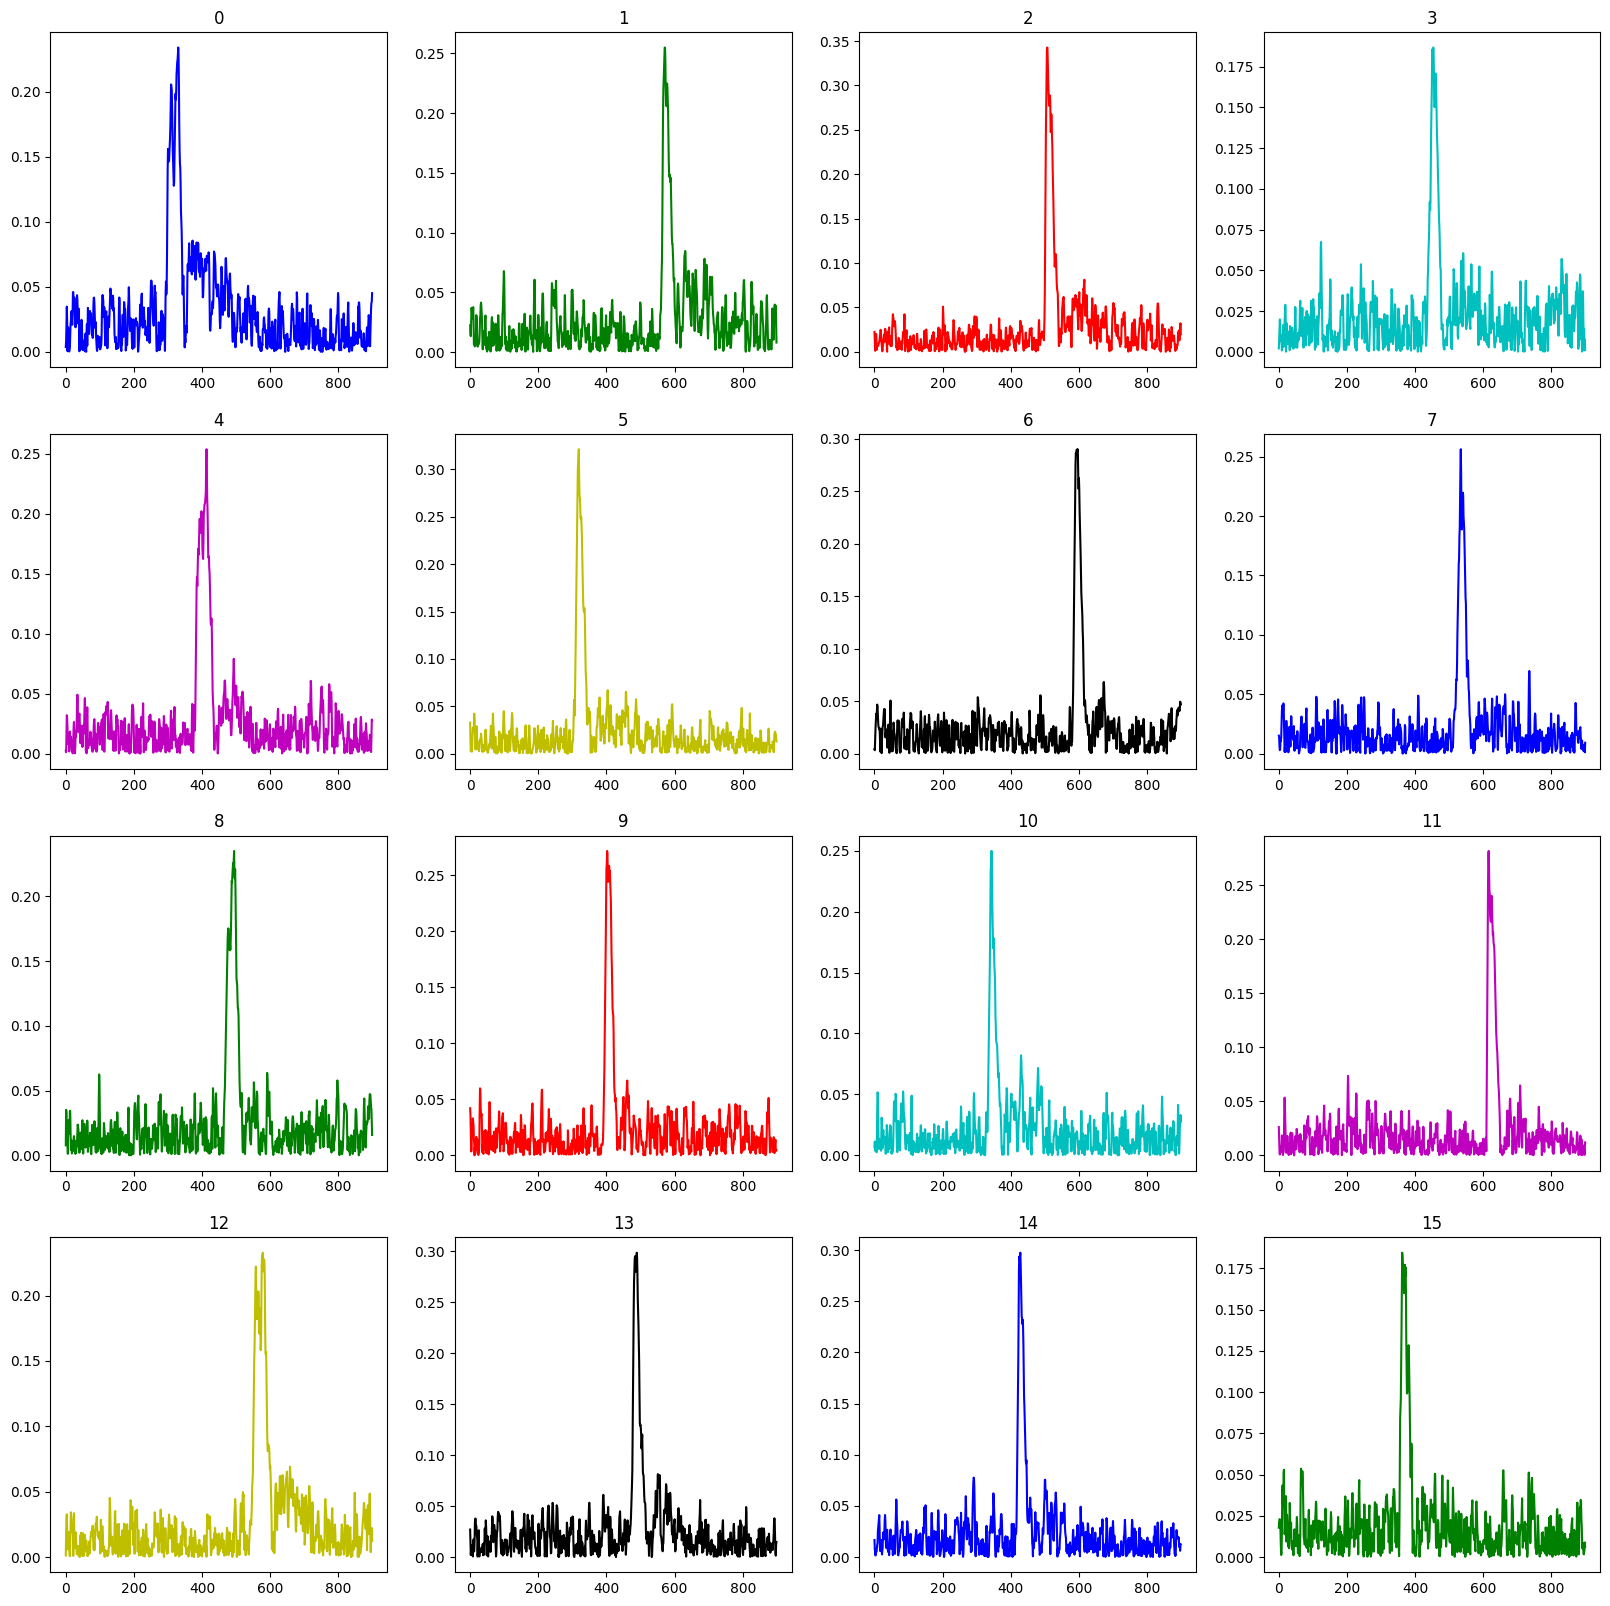

In [252]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fix, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
i = 0
for x in ax:
    for y in x:
        y.set_title(i)
        y.plot(corrs_max[i],label=i,color=colors[i%7])
        i += 1

In [224]:
def test_k(k_test):
    mk = sca_training.inverse_key_expansion(np.array(k_test))[0][0]
    flag = ''.join(chr(c) for c in mk)
    return flag.startswith('SCA') or flag.startswith('HEIG')

k = k10_max
for i in range(256):
    k[14] = i
    if test_k(k):
        print(k)
        break
print("Schade")

Schade
